In [1]:
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=4)

fatal: destination path 'nlp-with-transformers' already exists and is not an empty directory.
/home/jj/github/NLP/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.30.2


/home/jj/anaconda3/envs/deep/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using datasets v2.13.1
Using accelerate v0.20.3
Using sentencepiece v0.1.99
Using seqeval


다중 언어 트랜스포머는 많은 언어로 된 대규모 말뭉치에서 사전 훈련해서 '제로샷 교차 언어 전이 zero-shot cross-lingual transfer'가 가능하다.  
한 언어에서 미세 튜닝된 모델이 추가 훈련 없이 다른 언어에 적용된다는 의미이며,  
또 이런 모델은 한 대화에서 둘 이상의 언어나 사투리를 바꾸는 '코드 스위칭 code switching'에 적합하다.

※ 제로샷 전이 zero-shot transfer 또는 제로샷 학습 zero-shot learning은 일반적으로 한 레이블 집합에서 모델을 훈련한 다음 다른 레이블 집합에서 평가하는 작업을 의미한다.  
트랜스포머에서 제로샷 학습은 GPT-3 같은 언어 모델을 후속 작업에서 미세 튜닝하지 않고 평가하는 상황을 의미하기도 한다.

### 4장에서는 XLM-RoBERTa 트랜스포머 모델을 개체명 인식(NER을 수행하도록 여러 언어에서 미세 튜닝하는 방법을 알아볼 것.

NER은 텍스트에서 사람, 조직, 위치 같은 개체명을 식별하는 일반적인 NLP 작업으로, 다양한 애플리케이션에 사용한다.  
ex) 회사 문서에서 중요한 정보를 추출  
ex) 검색 엔진의 품질을 높임  
ex) 말뭉치에서 구조적인 데이터베이스를 만듦

이 장에서는 네 개의 공용어(영어가 언어를 이어주는 다리 역할을 하는 경우가 많다.)를 사용하며, 스위스에서 주로 활동하는 고객을 위해 NER을 수행한다고 가정한다.

# 4.1 데이터셋

WikiANN 또는 PAN-X라 불리는 교차 언어 전이 평가 (Cross-lingual TRansfer Evaluation of Multilingual Encoders; XTREME) 벤치 마크의 데이터를 사용.  
이 데이터는 여러 언어의 위키피디아 문서로 구성되고 스위스에서 사용되는 독일어, 프랑스어, 이탈리아어, 영어 네 개 언어로 작성되었다.  
#### 각 문서는 IOB2 포맷으로 LOC, PER, ORG 태그가 표시되어 있다.  
#### 이 포맷에서 B- 접두사는 개체명의 시작을 나타내고 동일한 개체명에 속해 연속되는 토큰에는 I- 접두사가 붙는다.  
#### O 태그는 토큰이 어떤 개체명에도 속하지 않음을 나타낸다.  
### 예를 들어, 다음 문장을 IOB2 포맷으로 나타내면 아래와 같다.

In [2]:
import pandas as pd
toks = "Jeff Dean is a computer scientist at Google in California".split()
lbls = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "O", "B-LOC"]
df = pd.DataFrame(data=[toks, lbls], index=['Tokens', "Tags"])
df

,0,1,2,3,4,5,6,7,8,9
Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC


XTREME에서 PAN-X 서브셋 중 하나를 로드하려면 load_dataset() 함수에 전달할 데이터셋 이름이 필요하다.  
여러 서브셋이 포함된 데이터셋을 다룰 때 어떤 서브셋이 제공되는지 확인하려면 get_dataset_config_names() 함수를 호출한다.  

In [3]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME 서브셋 개수: {len(xtreme_subsets)}")

XTREME 서브셋 개수: 183


### 검색 범위를 좁혀 'PAN'으로 시작하는 서브셋을 찾아보기  
str.startswith(prefix, start, end)  

str: 접두사를 확인할 대상 문자열입니다.  
prefix: 접두사로 확인할 문자열입니다.  
start (선택적): 문자열에서 접두사 확인을 시작할 위치를 지정합니다. 기본값은 0이며, 전체 문자열을 대상으로 확인합니다.  
end (선택적): 문자열에서 접두사 확인을 종료할 위치를 지정합니다. 기본값은 문자열의 끝을 나타내는 값입니다.  
반환값은 boolean

In [4]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
print(len(panx_subsets))
panx_subsets[:3]

40


['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

ISO 639-1 언어 코드로 보이는 두 문자로 된 접미사가 있다.  
독일어 말뭉치를 로드하려면 다음처럼 load_dataset() 함수의 name 매개변수에 독일어(de)에 해당하는 코드를 전달한다.

In [5]:
from datasets import load_dataset

load_dataset("xtreme", name="PAN-X.de")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 880.79it/s]


DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

사실적인 스위스 말뭉치를 만들기 위해 스위스에서 사용되는 언어 비율로 PAN-X에서 독일어de, 프랑스어fr, 이탈리아어it, 영어en 말뭉치를 샘플링한다.  
그러면 언어가 불균형한 데이터셋이 만들어지는데, 실제 데이터셋에서는 흔히 벌어지는 일이다.  
### 불균형한 이 데이터셋을 사용해 다중 언어 애플리케이션을 다룰 때 발생하는 일반적인 상황을 시뮬레이션하고, 모든 언어에서 작동하는 모델을 만드는 방법을 알아보자.

각 언어를 추적하기 위해 파이썬 defaultdict 객체를 만든다.  
다음으로 언어 코드를 키로 하고 DatasetDict 타입의 PAN-X 말뭉치를 값으로 저장한다.

1. defaultdict 객체:  
defaultdict는 파이썬의 collections 모듈에서 제공되는 사전(Dictionary)과 유사한 객체입니다.  
일반적인 사전과의 차이점은, defaultdict는 키(Key)가 존재하지 않을 때 자동으로 기본값(default value)을 할당하는 기능을 갖고 있습니다.  
기본값은 defaultdict 객체를 생성할 때 지정할 수 있습니다.

2. DatasetDict 타입:  
DatasetDict는 Hugging Face의 datasets 라이브러리에서 제공되는 자료구조입니다.  
DatasetDict는 데이터셋(Dataset)을 관리하기 위한 사전(Dictionary)과 유사한 구조를 가지고 있습니다.  
각각의 키(Key)에 해당하는 값(Value)으로 Dataset 객체를 저장합니다. 

In [6]:
from collections import defaultdict
from datasets import DatasetDict

langs = ["de", 'fr', 'it', 'en']
fracs = [0.629, 0.229, 0.084, 0.059]
# 키가 없는 경우 DatasetDict를 반환한다.
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # 다국어 말뭉치를 로드합니다.
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # 각 분할을 언어 비율에 따라 다운샘플링하고 섞습니다.
    for split in ds:
        panx_ch[lang][split] = ( # panx_ch라는 딕셔너리의 키 'de'의 value 값으로 저장된 딕셔너리의 키 'train' / 'de'가 [lang]이고 'train'이 [split]이다.
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac*ds[split].num_rows))) # .select() : 생성된 정수 범위를 사용하여 데이터셋에서 해당 행들을 선택한다. 즉, 정수 범위에 해당하는 행 인덱스를 가진 데이터만을 유지한다.
        )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 976.48it/s]


In [7]:
panx_ch

defaultdict(datasets.dataset_dict.DatasetDict,
            {'de': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 12580
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
             }),
             'fr': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 4580
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 2290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'la

In [8]:
for x in ds:
    print(x)

train
validation
test


데이터셋에 의도하지 않은 편향이 들어가지 않도록 shuffle() 메서드를 사용했다.  
select() 메서드는 fracs 값을 따라 각 말뭉치를 다운샘플링한다.  
Dataset.num_rows 속성으로 훈련 세트에 언어마다 얼마나 많은 샘플이 들어있는지 확인해보자.

In [9]:
import pandas as pd
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
            index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


의도한 대로 독일어 샘플은 그 외 언어를 모두 합친 것보다 많다.  
이 데이터셋을 사용해 제로샷 교차 언어 전이 zero-shot cross-lingual transfer를 프랑스어, 이탈리아어, 영어에 수행.  
### 독일어 말뭉치에 있는 샘플 하나를 확인해보자.

In [10]:
element = panx_ch["de"]["train"]

In [11]:
element

Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 12580
})

In [12]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der',
'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


앞서 본 Dataset 객체와 마찬가지로,  
이 샘플의 key는 애로우(Arrow) 테이블의 column name에 해당하고 value는 각 열에 있는 항목이다.  
특히 ner_tags 열은 각 개체명이 매핑된 클래스 ID에 해당한다.  
### 숫자만 보면 암호같으니 이해하기 쉽게 LOC, PER, ORG 태그로 새로운 열을 만들어보자.  
Dataset 객체는 각 열의 데이터 타입을 담은 features 속성을 가진다.

In [13]:
for key, value in panx_ch['de']['train'].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG',
'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


#### Sequence 클래스는 이 필드가 특성 리스트를 담고 있음을 나타낸다.  
#### ner_tags의 경우 ClassLabel의 리스트다.

# ------------------------------------------------------------------

In [14]:
panx_ch['de']['train']

Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 12580
})

In [15]:
panx_ch['de']['train'].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None),
 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [16]:
panx_ch['de']['train'].num_rows

12580

In [17]:
panx_ch['de']['train'].features['tokens']

Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)

In [18]:
panx_ch['de']['train'].features["ner_tags"]

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)

# ------------------------------------------------------------------

In [19]:
tags = panx_ch['de']['train'].features["ner_tags"].feature
print(type(tags))
print(tags)

<class 'datasets.features.features.ClassLabel'>
ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'],
id=None)


### 2장에서 본 ClassLabel.int2str() 메서드를 사용해 각 태그의 클래스 이름을 담은 새로운 열 (ner_tags_str)을 훈련 세트에 추가.  
map() 메서드에 하나의 dict를 반환하는 함수를 적용한다.  
이 딕셔너리의 키는 새로운 열 이름이고 값은 태그 클래스 이름의 list다.

In [20]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]} # panx_ch['de']['train']['ner_tags']에서 반환되는 데이터 자료형 안에 있는 숫자로 된 값들을 ClassLabel의 name으로 바꾼다.

panx_de = panx_ch['de'].map(create_tag_names)

In [21]:
panx_ch['de']

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 6290
    })
})

In [22]:
panx_de

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})

In [23]:
for x in panx_ch['de']['train']['ner_tags']:
    print(x)

[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
[0, 0, 0, 3, 0, 0, 0, 3, 4, 0, 0]
[0, 0, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 2, 0, 1, 2, 0, 1, 2, 0,
1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
2, 0]
[0, 0, 3, 4, 0, 0]
[0, 1, 2, 2, 2]
[0, 0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0]
[0, 0, 0, 0, 3, 4, 0, 0]
[0, 3, 4, 4, 4, 4, 4, 0]
[0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0]
[1, 2, 2, 2]
[0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0]
[0, 0, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 0]
[1, 2, 2]
[0, 0, 5, 0, 0]
[0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0]
[0, 0, 0, 0, 0, 5, 6, 6, 6, 0]
[3, 4, 0, 5]
[0, 5, 6, 6, 6]
[0, 0, 3, 0, 0, 0, 0]
[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 3, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 2, 2]
[0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 

[5, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 5, 6, 6]
[0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0]
[0, 0, 5, 0, 0, 0]
[5, 1, 0, 0, 0, 0, 0]
[3, 4, 0, 0]
[1, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 3, 1, 2, 0]
[0, 0, 3, 4, 4, 0, 0]
[5, 1, 2, 2, 0, 0, 0, 0]
[0, 1, 2, 2, 2]
[3, 4, 4, 4, 4, 4, 4]
[0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 3, 4, 4, 0, 0]
[0, 0, 1, 2, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0]
[5, 0, 5, 0, 5, 0, 5]
[3, 4, 4, 4, 4]
[0, 0, 3, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 3, 0]
[0, 0, 0, 0, 0, 0, 0, 3, 4, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 6, 0]
[0, 0, 3, 4, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0]
[0, 0, 0, 0, 0, 5, 0, 5, 0, 5, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 5, 0, 5, 0, 0]
[0, 3, 4, 0]
[5, 6, 6, 6, 6]
[1, 2, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 3, 4, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0]
[0, 0, 1, 2, 0, 0]
[1, 2, 2]
[0, 0, 0, 3, 0, 0]
[0, 0, 0, 0, 0, 5, 0]
[1, 2, 2, 2, 

[0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0]
[0, 0, 0, 3, 4, 4, 0, 0, 0, 0, 0]
[1, 2, 0, 1, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0]
[1, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 5, 6, 0, 0]
[0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 5, 6, 0, 5, 0, 0]
[0, 1, 2, 2]
[1, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0,
0]
[0, 0, 3, 4, 0, 0]
[0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 5, 6, 0, 0]
[0, 0, 0, 0, 5]
[0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 5, 0]
[1, 2, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 0]
[1, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 3, 1, 2, 2, 0, 0]
[1, 2, 2]
[0, 0, 0, 0, 3, 4, 4, 0, 0]
[0, 0, 0, 0, 0, 3, 4, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 0, 0]
[3, 4, 4, 4, 4]
[0, 0, 1, 2, 0, 0]
[0, 1, 2, 0, 1, 2, 0, 0, 0, 0, 0]
[1, 2, 2]
[0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 5, 0, 0, 0, 1, 2, 2, 0, 0]
[0, 0, 5, 6, 6]
[0, 0, 3, 0, 0]
[0, 0, 0, 0, 3, 4, 4

[1, 2, 2]
[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0]
[0, 0, 0, 0, 5, 0, 5, 0]
[0, 0, 0, 0, 3, 4, 0, 0]
[0, 0, 0, 0, 3, 0, 0, 0]
[5, 6, 6, 6]
[1, 2, 2]
[0, 0, 3, 4, 0, 0]
[0, 0, 1, 2, 0, 0, 0]
[0, 3, 0, 0, 0, 0]
[3, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 2, 2, 2, 2]
[0, 3, 4, 4, 4]
[0, 1, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0]
[0, 0, 0, 0, 3, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 2, 2, 0, 1, 2, 2]
[0, 0, 0, 3, 4, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 2, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 5, 6, 0, 0]
[5, 6, 6, 6, 6]
[0, 1, 2, 2, 2]
[5, 6, 6, 6]
[1, 2, 2, 0]
[3, 4, 0, 5]
[1, 2, 0, 0, 0, 0, 1, 2, 0, 1, 2, 0]
[0, 0, 5, 6, 0, 0, 0, 0, 0, 3, 4, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0]
[0, 0, 0, 0, 1, 2, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0]
[0, 0, 0, 5, 0]
[3, 0, 0, 0]
[0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 5, 0]
[1, 2, 2, 2, 2, 2, 2]
[1, 2, 2, 2, 2]
[0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0

[0, 0, 0, 0, 0, 3, 5, 0]
[0, 0, 5, 0, 0]
[0, 0, 0, 0, 3, 1, 0]
[0, 0, 0, 0, 1, 2, 2, 2, 0]
[0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 5, 6, 6, 0, 0, 0, 5, 0]
[0, 0, 0, 3, 0, 0]
[0, 0, 5, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 1, 2, 0, 0]
[0, 0, 0, 5, 0, 0, 5]
[1, 2, 0, 1, 2]
[1, 2, 0, 0, 0]
[0, 0, 0, 0, 0, 5, 3, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0]
[0, 3, 4, 4, 4]
[1, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 1, 2, 0, 0]
[1, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 0]
[0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0]
[0, 0, 5, 0, 0]
[0, 0, 5, 0, 5]
[0, 0, 5, 0, 0]
[0, 5, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 5, 0, 0]
[0, 0, 5, 0, 0]
[0, 0, 0, 3, 4, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0]
[0, 1, 2, 2]
[0, 0, 1, 2, 0]
[0, 0, 5, 6, 0, 0]
[0, 0, 5, 0, 5, 0, 5, 0, 5, 0, 0, 5, 6, 6]
[0, 0, 0, 0, 5, 6, 0, 5, 0, 5, 0]
[0, 5, 0, 5, 6, 0, 5, 0, 0, 0, 0, 0, 0]
[0, 0, 5, 0, 0]
[1, 2, 0, 1, 2, 0, 1, 2]
[0, 0, 0, 3, 4, 0, 5, 6, 0, 0, 0, 0, 0, 3, 4, 4, 4, 0

In [24]:
for x in panx_de['train']['ner_tags_str']:
    print(x)

['O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'B-LOC', 'B-LOC', 'I-LOC', 'O']
['O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O']
['O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'B-PER',
'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'B-PER',
'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER',
'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O',
'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER',
'O']
['O', 'O', 'B-ORG', 'I-ORG', 'O', 'O']
['O', 'B-PER', 'I-PER', 'I-PER', 'I-PER']
['O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
'B-LOC', 'O']
['O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O']
['O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O']
['O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
'B-LOC', 'O']
['B-PER', 'I-PER', 'I-PER', 'I-PER']
['O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', '

['O', 'B-PER', 'I-PER', 'I-PER']
['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O']
['O', 'B-ORG', 'I-ORG', 'I-ORG']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
'O', 'O', 'O']
['O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B-PER', 'I-PER', 'I-PER']
['O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O']
['O', 'O', 'B-LOC', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O']
['O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O']
['O', 'B-PER', 'I-PER', 'I-PER']
['O', 'B-PER', 'I-PER', 'I-PER']
['O', 'O', 'O', 'B-LOC', 'O', 'O']
['B-ORG', 'O', 'B-ORG', 'O', 'B-ORG', 'O', 'B-ORG', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'B-PER', 'I-PER']
['O', 'B-PER', 'I-PER', 'I-PER']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O',
'O', 'O']
['O', 'O', 'B-LOC', 'O', 'O']
['O', 'B-ORG', 'I-ORG', 'I

['O', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
'O', 'O', 'B-ORG', 'O', 'O', 'B-ORG', 'I-ORG', 'O']
['O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O']
['B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'B-ORG', 'I-ORG', 'O']
['O', 'O', 'O', 'O', 'B-LOC', 'B-LOC', 'I-LOC', 'O', 'B-LOC', 'O', 'B-LOC', 'O',
'B-LOC', 'O', 'B-LOC', 'O']
['O', 'O', 'B-PER', 'I-PER', 'O', 'O']
['O', 'O', 'B-ORG', 'I-ORG', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O']
['O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
'O', 'O', 'O', 'O', 'O']
['O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O']
['O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O']
['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'B-LOC', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-LOC',
'O', 'B-LOC', 'I-LOC', 'O', 'B-LOC', 'I-LOC', 'I-

['O', 'O', 'O', 'B-LOC', 'O', 'O']
['O', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-LOC', 'O']
['B-PER', 'I-PER', 'B-PER', 'I-PER', 'B-PER', 'I-PER']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O']
['O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O',
'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O']
['B-PER', 'I-PER', 'I-PER']
['B-PER', 'I-PER', 'I-PER']
['O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O']
['O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-ORG', 'O', 'O', 'O', 'B-ORG',
'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['B-ORG', 'I-OR

['O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O',
'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O']
['O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B-PER', 'I-PER', 'I-PER']
['O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O']
['O', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER']
['B-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER']
['O', 'O', 'B-LOC', 'I-LOC', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER',
'I-PER', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-LOC',
'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O']
['O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O']
['B-PER', 'I-PER', 'I-PER']
['B-P

['O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'B-PER',
'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER',
'O', 'B-PER', 'I-PER', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O',
'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O']
['B-LOC', 'I-LOC', 'I-LOC', 'I-LOC']
['O', 'O', 'B-ORG', 'I-ORG', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O']
['O', 'B-LOC', 'I-LOC', 'I-LOC']
['O', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'I-PER']
['B-PER', 'I-PER', 'I-PER', 'I-PER']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
'O', 'O', 'O', 'O', 'B-PER', 'O', 'O']
['B-ORG', 'O', 'O', 'B-PER', 'I-PER']
['O', 'O', 'B-LOC', 'O', 'O']
['O', 'O', 'B-LOC', 'O', 'O']
['B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O']
['B-PER', 'I-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'I-PER']
['O', 'O', 'O', 'O', '

### 이제 태그를 읽기 좋게 변환했으니 훈련 세트에 있는 첫 번째 샘플의 토큰과 태그 이름을 나란히 출력해보자.

In [25]:
df

,0,1,2,3,4,5,6,7,8,9
Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC


# --------------------------------------------------------------

In [26]:
panx_de['train']['ner_tags_str'][0]

['O',
 'O',
 'O',
 'O',
 'B-LOC',
 'I-LOC',
 'O',
 'O',
 'B-LOC',
 'B-LOC',
 'I-LOC',
 'O']

In [27]:
panx_de['train'][0]    

{'tokens': ['2.000',
  'Einwohnern',
  'an',
  'der',
  'Danziger',
  'Bucht',
  'in',
  'der',
  'polnischen',
  'Woiwodschaft',
  'Pommern',
  '.'],
 'ner_tags': [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0],
 'langs': ['de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de'],
 'ner_tags_str': ['O',
  'O',
  'O',
  'O',
  'B-LOC',
  'I-LOC',
  'O',
  'O',
  'B-LOC',
  'B-LOC',
  'I-LOC',
  'O']}

In [28]:
panx_de['train'][0]['tokens']

['2.000',
 'Einwohnern',
 'an',
 'der',
 'Danziger',
 'Bucht',
 'in',
 'der',
 'polnischen',
 'Woiwodschaft',
 'Pommern',
 '.']

In [29]:
panx_de['train'][0]['ner_tags_str']

['O',
 'O',
 'O',
 'O',
 'B-LOC',
 'I-LOC',
 'O',
 'O',
 'B-LOC',
 'B-LOC',
 'I-LOC',
 'O']

In [30]:
for token, tag in zip(panx_de['train'][0]['tokens'], panx_de['train'][0]['ner_tags_str']):
    print(f"token: {token} -> {tag}")

token: 2.000 -> O
token: Einwohnern -> O
token: an -> O
token: der -> O
token: Danziger -> B-LOC
token: Bucht -> I-LOC
token: in -> O
token: der -> O
token: polnischen -> B-LOC
token: Woiwodschaft -> B-LOC
token: Pommern -> I-LOC
token: . -> O


In [31]:
de_example = panx_de['train'][0]

df = pd.DataFrame([de_example['tokens'], de_example['ner_tags_str']],
                 index=['Tokens', 'Tags'])

# --------------------------------------------------------------

### 태그가 불균형하게 부여되지 않았나 확인하기 위해 각 분할에서 개체명의 빈도를 계산해보자.

In [32]:
from collections import Counter
# Counter 생성자는 여러 형태의 데이터를 인자로 받는데요. 먼저 중복된 데이터가 저장된 배열을 인자로 넘기면 각 원소가 몇 번씩 나오는지가 저장된 객체를 얻게 됩니다.
Counter(["hi", "hey", "hi", "hi", "hello", "hey"])

Counter({'hi': 3, 'hey': 2, 'hello': 1})

In [33]:
counter = Counter("hello world")
counter["o"], counter["l"]

(2, 3)

In [34]:
counter["o"] += 1
counter["o"]

3

In [35]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items(): # split : 'train'/'validation'/'test' 그리고 dataset은 딕셔너리 형태로 features, num_rows 키값을 가짐
    for row in dataset["ner_tags_str"]: # row = text의 각 문장이 토큰화되어 하나의 리스트로 있음
        for tag in row: # tag = 하나의 토큰에 대한 태그
            if tag.startswith("B"): # 만약 토큰이 B로 시작하면
                tag_type = tag.split("-")[1] # B-를 뺀 뒤에 부분이 tag_type이다.
                split2freqs[split][tag_type] += 1 # B-라는 태그는 개체명의 시작이며 I-라는 태그는 하나의 개체에서 떨어져 나온 토큰이므로 개체의 개수를 세기 위해 B- 로 시작하는 토큰만 사용.

pd.DataFrame.from_dict(split2freqs, orient='index')

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


In [36]:
for x in panx_de.items():
    print(x)

('train', Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
    num_rows: 12580
}))
('validation', Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
    num_rows: 6290
}))
('test', Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
    num_rows: 6290
}))


In [37]:
split2freqs

defaultdict(collections.Counter,
            {'train': Counter({'LOC': 6186, 'ORG': 5366, 'PER': 5810}),
             'validation': Counter({'ORG': 2683, 'LOC': 3172, 'PER': 2893}),
             'test': Counter({'LOC': 3180, 'PER': 3071, 'ORG': 2573})})

### 결과를 보니 PER, LOC, ORG 빈도 분포가 대체로 각 분할에서 동일하다. 
### 따라서 이 검증 세트와 테스트 세트는 NER 태그의 일반화 능력을 평가하는데 적절하다고 할 수 있다.

# 4.2 다중 언어 트랜스포머

다중 언어 트랜스포머의 훈련 과정과 아키텍처는 단일 언어 트랜스포머와 비슷하다.  
### 다만 사전 훈련에 사용하는 말뭉치가 여러 언어의 문서로 구성될 뿐이다.
### 언어의 차이에 대한 정보가 명시적으로 제공되지 않아도, 이렇게 구축한 언어 표현이 여러 언어의 문서로 구성될 뿐이다.

교차 언어 전이를 수행하는 이런 능력이 경우에 따라 단일 언어 모델과 비슷한 결과를 내므로 언어마다 별도의 모델을 훈련할 필요가 없다.

NER에 대한 교차 언어 전이의 과정을 측정하기 위해 CoNLL-2002와 CoNLL-2003 데이터셋이 영어, 네덜란드어, 스페인어, 독일어를 위한 벤치마크로 많이 사용된다.  
이 벤치마크는 PAN-X와 동일하게 개체명이 LOC, PER, ORG 태그로 분류된 뉴스 기사로 구성된다. 하지만 세 카테고리에 속하지 않는 개체명을 위해 MISC 레이블이 추가된다.  
다중 언어 트랜스포머 모델은 일반적으로 세 가지 방식으로 평가한다.

1) en  
  영어 훈련 데이터에서 미세 튜닝한 다음에 각 언어의 테스트 세트에서 평가한다.
  
  
2) each  
  언어별 성능을 측정하기 위해 단일 언어의 테스트 세트에서 미세 튜닝하고 평가한다.
  
  
3) all  
  모든 훈련 데이터에서 미세 튜닝해 각 언어의 테스트 세트에서 평가한다.

### NER 작업에 비슷한 평가 전략을 적용해보자.  
먼저 평가할 모델부터 선택한다.  
초기의 다중 언어 트랜스포머중 하나는 mBERT다.  
사전 훈련 목표가 BERT의 아키텍처와 동일하지만 사전 훈련 말뭉치에 다양한 언어의 위키피디아 문서가 추가됐고, 이후 XLM-RoBERTa(약칭 XLM-R)로 대체되었다.

3장에서 보앗듯 XLM-R은 사전 훈련 목표로 100개 언어에 대한 MLM만 사용한다.  
하지만 이전 모델에 비해 사전 훈련 말뭉치가 매우 크다.  
각 언어의 위키피디아 덤프와 2.5테라바이트의 커먼 크롤 웹 데이터를 사용한다.  
#### 이 말뭉치는 초기 모델에서 사용한 데이터보다 몇 배가 더 크며 위키피디아 문서가 적은 버마어(Burmese)나 스와힐리어 같은 희소 언어에 대한 성능을 크게 높인다.

모델명에 RoBERTa가 붙은 이유는 사전 훈련 방식이 단일 언어 모델 RoBERTa와 같기 때문이다.  
RoBERTa는 '다음 문장 예측(NSP)' task를 제거하며 BERT의 성능을 크게 높였다.  
#### XLM-R은 XLM에서 사용하는 언어 임베딩도 제거하고 SentencePiece를 사용해 원시 텍스트를 직접 토큰화한다.
XLM-R이 다중 언어라는 특징 외에 두 모델의 큰 차이점은 어휘사전의 크기다.  
사용하는 토큰 개수는 RoBERTa는 55,000개지만 XLM-R은 250,000개다.

### XLM-R은 다국어 NLU 작업에 잘 맞는 모델이다.

# 4.3 XLM-R 토큰화
XLM-R은 WordPiece 토크나이저 대신 100개의 언어 텍스트에서 훈련된 SentencePiece라는 토크나이저를 사용한다.
### SentencePiece를 WordPiece와 비교해보자

In [38]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = 'xlm-roberta-base'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

### 짧은 텍스트 시퀀스를 인코딩해서 각 모델이 사전 훈련 동안에 사용하는 특수 토큰을 확인해보자

In [39]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [40]:
df = pd.DataFrame([bert_tokens, xlmr_tokens], index=["BERT", "XLM-R"])
df

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


#### BERT가 문장 분류 작업에 사용하는 [CLS]와 [SEP] 토큰 대신에, XLM-R은 \<s>와 \</s>를 사용해 시퀀스의 처음과 끝을 표시한다.  
잠시 후에 보겠지만 이런 토큰은 토큰화 마지막 단계에 추가된다.

## 4.3.1 토큰화 파이프라인
사실 토큰화는 문자열을 모델에 주입할 정수로 변환하는 연산하는 작업만 하는 것이 아니다.  
#### 실제로는 (정규화) -> (사전 토큰화) -> (토크나이저 모델) -> (사후 처리)의 4가지 단계로 구성된다.

### 정규화
-> 원시 문자열을 더 '깨끗하게' 만들기 위해 적용하는 연산  
-> 대개 공백과 악센트가 붙은 문자를 제거하는 작업 등  
-> 유니코드 정규화(NFC, NFD, NFKC, NFKD 같은 다양한 방법이 있음)  
-> 소문자로 바꾸는 작업

### 사전 토큰화 pretokenization
-> 텍스트를 더 작은 객체로 분할하며 마지막에 생성되는 토큰의 상한선을 제공  
-> 즉, 사전토큰화가 텍스트를 단어로 분할하고 최종 토큰은 이 단어의 일부가 된다는 뜻  
-> 일반적으로 공백과 구두점을 기준삼아 단어로 분할됨.  
-> 단어로 분할하는 것이 항상 올바르지는 않다. (한극,일본,중국의 언어에서 인도-유럽어족 단어와 같은 의미 단위로 기호를 모으면 똑같이 유효한 여러 그룹이 만들어지는 비결정적 연산이 된다.)  
-> 이 경우에는 텍스트를 사전 토큰화하는 대신 언어별 사전 토큰화 라이브러리를 사용하는 것이 좋다.

### 토크나이저 모델
-> 입력 텍스트 정규화와 사전 토큰화를 수행하고 난 후 토크나이저를 사용해 부분단어 분할 모델을 단어에 적용한다.  
-> (토크나이저는 파이프라인에서 말뭉치로 훈련이 필요한 부분이다.)  
-> (그렇지 않고 사전 훈련된 토크나이저를 사용한다면 이미 훈련된 상태로 볼 수 있다.)  
-> 이 모델은 단어를 부분단어로 나눠 어휘사전의 크기와 OOV 토큰의 개수를 줄이는 역할을 한다.  
-> 부분단어 토큰화 알고리즘에는 BPE, 유니그램, WordPiece 등이 있다.  
-> 이 시점부터 더 이상 문자열 리스트가 아니라 정수(입력 ID를 말함) 리스트를 가지게 된다. ★

### 사후처리
-> 토큰화 파이프라인의 마지막 단계로, 토큰 리스트에 부가적인 변환을 적용할 때도 있다.  
-> 가령 입력 토큰 인덱스의 시퀀스 처음과 끝에 특수 토큰을 추가하는 경우  
-> (BERT 스타일의 토크나이저는 분류 토큰(CLS)와 분할 토큰 (SEP)를 추가한다.)  
-> 그다음 모델에 시퀀스를 주입한다.(문자열 말고 정수로 된 시퀀스임)

XLM-R과 BERT의 비교로 돌아가면, SentencePiece는 사후 처리 단계에서 [CLS]와 [SEP] 대신 \<s>와 \</s>를 추가한다.

## 4.3.2 SentencePiece 토크나이저
SentencePiece 토크나이저는 '유니그램'이라는 부분단어 분할 방식을 기반으로 각 입력 텍스트를 유니코드 문자 시퀀스로 인코딩한다.  
SentencePiece가 악센트, 구두점에 대해 몰라도 되므로 이 특징은 다국어 말뭉치에 특히 유용하다.(일본어 등의 많은 언어에 공백 문자가 있지 않다는 사실도 몰라도 된다.)  

SentencePiece의 또 다른 고유한 특징은 공백 문자가 유니코드 기호 U+2581 또는 아래 1/4 블록 문자 (lower one quarter block character)라고도 하는 _ 문자에 할당된다는 것이다.  
따라서 SentencePiece는 언어별 사전 토크나이저에 의존하지 않고 정확하게 시퀀스를 복원한다.  
이전 절의 예시 문장에서 WordPiece는 'York'와 '!' 사이에 공백이 없다는 정보를 잃어버린다.  
#### 이와 달리 SentencePiece는 토큰화된 텍스트에 공백을 보존하기 때문에 정확하게 원시 텍스트로 다시 변환한다.

In [41]:
"".join(xlmr_tokens)

'<s>▁Jack▁Sparrow▁loves▁New▁York!</s>'

In [42]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

#### 이제 SentencePiece의 작동원리를 이해했으니 간단한 샘플을 NER에 적합한 형태로 인코딩 하는 방법을 알아볼 차례.
#### 먼저 토큰 분류 헤드와 함께 사전 훈련된 모델을 로드한다. (하지만 이 헤드를 트랜스포머스에서 로드하지 않고 직접 만들어볼 예정)

# 4.4 개체명 인식을 위한 트랜스포머

BERT는 텍스트 분류를 위해 특수 토큰 [CLS]로 전체 텍스트 시퀀스를 표현한다.  
이 표현을 완전 연결 또는 밀집 층에 통과시켜 이산적인 레이블 값을 출력한다.

입력 텍스트 -> 토큰 -> 트랜스포머 인코더 -> 은닉 상태 -> 밀집 층 -> 레이블

BERT와 그 외 인코더 기반 트랜스포머는 NER 작업에 비슷한 방식을 사용한다.  
다만 입력 토큰의 표현이 완전 연결 층에 주입되어 해당 토큰의 개체명을 인식한다.  
이런 이유로 NER을 종종 토큰 분류 작업으로 생각하기도 한다.

입력 텍스트 -> 토큰 -> 트랜스포머 인코더 -> 은닉 상태 -> 밀집 층 -> 태그 (위에 레이블이나 태그나 같은거 말하는거임)

# 4.5 트랜스포머 모델 클래스

트랜스포머스는 아키텍처와 작업마다 전용 클래스를 제공한다.  
작업에 연관된 모델 클래스의 이름은 \<ModelName>For\<Task> 형식을 따른다.  
AutoModel 클래스를 사용하는 경우 AutoModelFor\<Task>와 같다.

하지만 이 방식은 한계가 있다.  
예를 들어, 해결하려는 가상의 작업(Task)이 'TaskXY'라고 할 때, from transformers import BertForTaskXY를 했지만 해당 작업에 맞는 BERT 모델이 없다고 한다.  
전체 모델을 직접 구현해야 한다면 빠른 시일 내에 가상의 작업을 해결할 수 있겠는가?

### 트랜스포머스는 기존 모델을 특정 작업에 맞춰 쉽게 확장 가능하도록 설계됐다.  
### 사전 훈련된 모델에서 가중치를 로드하고 작업에 특화된 헬퍼 함수를 사용한다.  
### 따라서 아주 조금만 수고하면 특정 용도의 사용자 정의 모델을 만들 수 있다. (이 절에서 그 방법을 알아보자.)

## 4.5.1 바디와 헤드
트랜스포머스의 다재자능한 능력은 바디와 헤드로 나뉜 모델 구조에서 나온다.  
이 구조는 사전 훈련된 모델을 후속 작업에 맞게 바꿀 때 이미 보았다.  
-> 모델의 마지막 층이 후속 작업에 맞는 층으로 바뀌는데, 이 마지막 층이 모델의 헤드이며 작업에 특화된다.  
-> 모델의 나머지 부분을 바디라 한다. 여기에는 작업에 특화되지 않은 토큰 임베딩과 트랜스포머 층이 포함된다.  

이 구조는 트랜스포머스 코드에도 반영된다.  
모델의 바디는 BertModel 또는 GPT2Model 같은 클래스로 구현되며 (바디에 있는) 마지막 층의 은닉상태를 반환한다.  
BertForMaskedLM 또는 BertForSequenceClassification 같이 작업에 특화된 모델은 베이스 모델을 사용하고 마지막 은닉 상태 위에 필요한 헤드를 추가한 것이다.
### 바디와 헤드가 분리된 구조 덕분에 특정 작업을 위해 만든 사용자 정의 헤드를 사전 훈련된 모델에 장착할 수 있다.

## 4.5.2 토큰 분류를 위한 사용자 정의 모델 만들기

#### XLM-R에 대한 사용자 정의 토큰 분류 헤드를 만드는 예제

XLM-R은 RoBERTa와 모델 구조가 동일하니 RoBERTa를 베이스 모델로 사용하되 특화된 설정을 추가해보자.  
이 예제는 자신의 작업에 맞는 모델을 만드는 방법을 배우기 위한 것이다.  
토큰 분류의 경우 트랜스포머스에서 임포트하는 XLMRobertaForTokenClassification 클래스가 이미 있다.(XLMRobertaForTokenClassification 클래스는 사실 XLMRobertaConfig를 사용하는 RobertaForTokenClassification이다.)  

#### 먼저 XLM-R NER 태그를 표현할 데이터 구조가 필요하다.  
추측건대 모델을 초기화할 설정 객체와 출력을 생성할 forward() 함수가 필요할 것이다.  
토큰 분류를 위한 XLM-R 클래스를 만들어보자

config는 모델의 설정(configuration)을 나타내는 객체.  
이 설정은 모델의 아키텍처와 관련된 매개변수를 정의하며, 학습, 추론, 또는 전이 학습과 같은 작업에 필요한 다양한 하이퍼파라미터를 지정한다.  
트랜스포머 라이브러리에서는 일반적으로 JSON 또는 Python 클래스의 형태로 config 객체를 사용합니다.  
이러한 config를 사용하여 트랜스포머 모델을 초기화하고 원하는 하이퍼파라미터와 아키텍처 설정을 지정할 수 있습니다.

In [43]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig
    
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # 모델 바디를 로드
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # 토큰 분류 헤드를 준비
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # 가중치를 로드하고 초기화한다.
        self.init_weights()
    
    def forward(self, input_ids=None, attention_mask = None, token_type_ids = None, labels = None, **kwargs):
        # 먼저 모델 바디를 사용해 인코더 표현을 얻는다.
        outputs = self.roberta(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               **kwargs)
        
        # 그리고 인코더 표현을 헤드에 통과시킨다.
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        
        # 손실을 계산한다.
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        # 모델 출력 객체를 반환한다.
        return TokenClassifierOutput(loss = loss, logits=logits,
                                    hidden_states=outputs.hidden_states,
                                    attentions=outputs.attentions)

#### init 부분

config_class는 새로운 모델을 초기화할 때 표준 XLM-R 설정을 사용하도록 도와준다. (기본값을 바꾸고 싶다면 기본 설정을 덮어쓰면 된다.)  
config_class는 RobertaPreTrainedModel의 부모 클래스 PreTrainedModel의 클래스 변수다.  
이 변수에 모델 구조로 사용할 설정 클래스(PretrainedConfig의 서브 클래스)를 지정한다.  

super() 메서드로 RobertaPreTrainedModel 클래스의 초기화 함수를 호출한다.  
이 추상 클래스는 사전 훈련된 가중치의 초기화나 로딩을 처리한다.

그다음 모델 바디 RobertaModel을 로드하고 드롭아웃 층과 피드 포워드 충으로 구성된 분류 헤드를 추가한다.  
add_pooling_layer=False로 지정해서 [CLS]토큰에 해당하는 은닉 상태 외에 모든 은닉 상태가 반환되도록 한다.  
(add_pooling_layer의 기본값은 True로 첫 번째 토큰의 은닉 상태만 밀집 층과 활성화 함수에 통과시켜 출력한다.)

마지막으로, RobertaPreTrainedModel 클래스에서 상속된 init_weights() 메서드를 호출해 가중치를 초기화한다.  
모델 바디에 사전 훈련된 가중치가 로드되고 토큰 분류 헤드의 가중치가 랜덤하게 초기화 될 것이다.  
(init_weights() 메서드는 PreTrainedModel 클래스에 정의되며 RobertaPreTrainedModel 클래스에 정의된 __init__weights() 메서드를 사용해 층의 가중치를 초기화한다.  
init_weights()를 직접 호출하는 대신 이 메서드 호출을 담당하는 post_init() 메서드를 사용하는 것이 좋다.)

#### forward 부분

정방향 패스 과정에서 데이터는 먼저 모델의 바디에 주입된다.  
여러 개의 입력 변수가 있지만 지금 필요한 것은 input_ids와 attention_mask뿐이다.  
그다음 모델 바디가 출력한 은닉 상태를 드롭아웃 층과 분류 층에 통과시킨다.  
정방향 패스에서 레이블을 전달했다면 바로 손실이 계산된다.  
어텐션 마스크가 있다면 마스킹되지 않은 토큰의 손실만 계산하기 위해 해야 할 일이 조금 더 많다.  
마지막으로 2장에서 소개한 네임드 튜플로 원소를 참조할 수 있도록 출력을 TokenClassifierOutput 객체로 감싼다.

간단한 클래스에 두 개의 함수를 구현하면 사용자 정의 트랜스포머 모델이 만들어진다.  
PreTrainedModel 클래스를 상속했으므로 from_pretrained() 같은 유용한 트랜스포머스 유틸리티가 모두 사용 가능하다.  
#### 이제 사전 훈련된 가중치를 사용자 정의 모델에 로드하는 방법을 알아보자.

## 4.5.3 사용자 정의 모델 로드하기

토큰 분류 모델을 로드할 준비를 마쳤다.  
모델 이름 외에 몇 가지 정보를 추가해야 한다.  
각 개체명을 레이블링하는데 사용할 태그, 각 태그를 ID로 매핑하는 딕셔너리와 그 반대로 매핑하는 딕셔너리다.  
이런 정보는 모두 ClassLabel 객체인 tags 변수의 names 속성을 사용해 매핑된다.

In [44]:
index2tag = {idx:tag for idx, tag in enumerate(tags.names)}
tag2index = {tag:idx for idx, tag in enumerate(tags.names)}

In [45]:
tags

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [46]:
tags.num_classes

7

#### 3장에서 본 AutoConfig 객체에 이런 매핑과 tags.num_classes 속성을 저장한다.  
from_pretrained() 메서드의 키워드 매개변수로 전달해 기본값을 오버라이드한다.

In [47]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                        num_labels=tags.num_classes,
                                        id2label=index2tag,
                                        label2id=tag2index)

AutoConfig 클래스는 모델 구조의 청사진을 가진다.  
AutoModel.from_pretrained(model_ckpt)로 모델을 로드할 때 모델에 연관된 설정 파일이 자동으로 다운로드 된다.  
(xlmr_config를 따로 전달하지 않으면, config_class 변수에 지정된 XLMRobertaConfig 클래스의 from_pretrained()메서드를 호출해 (BERT 같은) 기본값이 지정된 설정 객체를 생성한다.)  
하지만 클래스 개수나 레이블 이름 등을 수정하고 싶다면 커스터마이징하려는 매개변수로 이 설정 파일을 먼저 로드한다.  

#### 이제 config 매개변수를 추가한 다음, 이전처럼 from_pretrained() 함수를 사용해 모델 가중치를 로드한다.  
모델 클래스에 사전 훈련된 가중치를 로드하는 코드를 작성하지 않았지만, RobertaPreTrainedModel을 상속했으니 다음과 같이 로드할 수 있다.

In [49]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

In [55]:
device

device(type='cuda')

#### 토크나이저와 모델을 바르게 초기화했는지 빠르게 확인하기 위해 개체명을 알고 있는 작은 시퀀스의 예측 결과를 보자.  
#### 먼저 텍스트를 입력 ID로 변환한다.

In [51]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input_IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input_IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


시작 \<s>와 끝 \</s> 토큰은 각각 ID 0과 2다.  
토크나이저의 encode() 메서드는 토크나이저를 호출했을 때 반환되는 딕셔너리 중 input_ids 키에 해당하는 값만 반환하는 메서드다.

# -------------------------------------------------------------------------------

In [52]:
input_ids

tensor([[    0, 21763, 37456, 15555,  5161,     7,  2356,  5753,    38,     2]])

In [53]:
a = xlmr_tokenizer.encode(text)
a

[0, 21763, 37456, 15555, 5161, 7, 2356, 5753, 38, 2]

In [54]:
b = xlmr_tokenizer(text)
b

{'input_ids': [0, 21763, 37456, 15555, 5161, 7, 2356, 5753, 38, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [55]:
b["input_ids"]

[0, 21763, 37456, 15555, 5161, 7, 2356, 5753, 38, 2]

In [56]:
c = xlmr_tokenizer(text, return_tensors="pt")
c

{'input_ids': tensor([[    0, 21763, 37456, 15555,  5161,     7,  2356,  5753,    38,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [57]:
print(type(input_ids))
print(type(a))
print(type(b))
print(type(b["input_ids"]))
print(type(c))
print(type(c["input_ids"]))

<class 'torch.Tensor'>
<class 'list'>
<class 'transformers.tokenization_utils_base.BatchEncoding'>
<class 'list'>
<class 'transformers.tokenization_utils_base.BatchEncoding'>
<class 'torch.Tensor'>


# -------------------------------------------------------------------------------

#### 마지막으로, 모델에 입력 ID를 전달하고 argmax 함수로 토큰마다 확률이 가장 높은 클래스를 선택해 예측을 만든다.

In [58]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"시퀀스에 있는 토큰 개수: {len(xlmr_tokens)}")
print(f"출력 크기: {outputs.shape}")

시퀀스에 있는 토큰 개수: 10
출력 크기: torch.Size([1, 10, 7])


로짓의 크기는 [batch_size, num_tokens, num_tags]다.  
즉, 각 토큰에는 일곱개의 NER 태그와 로짓이 주어진다.  
#### 사전 훈련된 모델의 예측 결과를 태그 이름으로 바꿔 토큰과 함께 확인해보자.

In [59]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC


예상대로 랜덤한 가중치를 가진 토큰 분류층은 개선할 여지가 많다.  
### 레이블링된 데이터로 미세 튜닝해서 결과를 더 좋게 만들어보자.

#### 훈련을 시작하기 전, 나중을 위해 앞의 과정을 하나의 헬퍼 함수로 만들어보자.

In [50]:
def tag_text(text, tags, model, tokenizer):
    # 토큰을 준비한다.
    tokens = tokenizer(text).tokens()
    # 시퀀스를 입력 ID로 인코딩한다.
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # 가능한 일곱 개의 클래스에 대한 분포를 예측한다.
    outputs = model(input_ids)[0]
    # 토큰마다 가장 가능성 있는 클래스를 argmax로 구합니다.
    predictions = torch.argmax(outputs, dim=2)
    # 데이터프레임으로 변환한다.
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [61]:
tags.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [62]:
type(predictions)

torch.Tensor

In [63]:
predictions.shape

torch.Size([1, 10])

In [64]:
predictions[0]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')

In [65]:
preds

['I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC']

In [66]:
xlmr_tokens

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']

#### 모델을 훈련하기 전에, 다음 절에서 입력을 토큰화하고 레이블을 준비한다.

# 4.6 NER 작업을 위해 텍스트 토큰화하기

하나의 샘플을 인코딩하고 처리하는 토크나이저와 모델을 준비했으므로  
다음 단계는 미세 튜닝을 위해 XLM-R 모델에 전달할 전체 데이터셋을 토큰화 하는 것이다.

2장에서 보앗듯 데이터셋은 map() 연산으로 Dataset 객체를 빠르게 토큰화한다.  
#### 이를 위해 먼저 다음처럼 간단한 시그니처를 가진 함수를 정의
function(examples: Dict[str, List]) -> Dict[str, List]

여기서 examples는 Dataset의 슬라이스 하나에 해당한다.  
예를 들면 panx_de['train'][:10]이다.

XLM-R 토크나이저는 모델 입력을 위해 입력 ID를 반환한다.  
따라서 반환된 결과에 어텐션 마스크와 각 토큰에 어떤 NER 태그가 연관됐는지 인코딩하는 레이블 ID를 추가한다.

트랜스포머스 문서(https://bit.ly/3y6z3kc) 에 언급된 방법을 따라 독일어 샘플 문장 하나를 사용해 어떻게 하는지 알아보자
#### 먼저 평범한 리스트로 단어와 태그를 준비한다.

In [48]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [49]:
words

['2.000',
 'Einwohnern',
 'an',
 'der',
 'Danziger',
 'Bucht',
 'in',
 'der',
 'polnischen',
 'Woiwodschaft',
 'Pommern',
 '.']

In [50]:
labels

[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]

#### 그다음 각 단어를 토큰화한다. 
토크나이저에 is_split_into_words 매개변수를 사용해 입력 문장이 이미 단어로 나눠졌다는 사실을 전달한다.

In [69]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [70]:
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [71]:
tokenized_input

{'input_ids': [0, 70101, 176581, 19, 142, 122, 2290, 708, 1505, 18363, 18, 23, 122, 127474, 15439, 13787, 14, 15263, 18917, 663, 6947, 19, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [72]:
tokens

['<s>',
 '▁2.000',
 '▁Einwohner',
 'n',
 '▁an',
 '▁der',
 '▁Dan',
 'zi',
 'ger',
 '▁Buch',
 't',
 '▁in',
 '▁der',
 '▁polni',
 'schen',
 '▁Wo',
 'i',
 'wod',
 'schaft',
 '▁Po',
 'mmer',
 'n',
 '▁',
 '.',
 '</s>']

이 예에서 토크나이저는 'Einwohnern'을 두 개의 부분단어 '_Einwohner'와 'n'으로 나눴다.(_는 공백표시)  
#### '_Einwohner'만 B-LOC 레이블에 연결한다는 규칙을 따라야 하므로 첫 번째 부분단어 이후의 부분단어는 마스킹한다.★  
다행히 tokenized_input 객체에는 이 작업에 도움되는 word_ids() 메서드가 있다.

In [73]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word_IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word_IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


word_ids는 각 부분단어를 words 리스트(= de_example["tokens"])에 있는 해당 단어의 인덱스에 매핑한 것이다.  
따라서 첫 번째 부분단어 '_2.000'는 인덱스 0이고,  
'Einwohnern'은 words에 있는 두 번째 단어이므로 '_Einwohner'와 'n'은 인덱스 1에 할당된다.  
\<s>와 \</s> 같은 특수 토큰은 None에 매핑됐다.  
#### 이런 특수 토큰과 부분단어의 레이블을 -100으로 설정해 훈련하는 동안 마스킹처리하도록 한다.

In [74]:
labels

[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]

In [75]:
word_ids

[None,
 0,
 1,
 1,
 2,
 3,
 4,
 4,
 4,
 5,
 5,
 6,
 7,
 8,
 8,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 11,
 11,
 None]

In [76]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100) # 현재 토큰이 이전 토큰과 동일한 단어 출신이라면 -100, 특수토큰 <s> </s>여도 -100
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx]) # 처음나오는 단어의 첫 번째 토큰이라면 해당 토큰이 속한 단어의 태그번호를 집어넣음.
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids] # label_ids를 차례대로 꺼내서 100이면 IGN을, 아니라면 index2tag로 매핑된 단어 태그를 집어넣기
index = ["Tokens", "Word_IDs", "Label_IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word_IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label_IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [51]:
index2tag

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC'}

#### 부분단어 표현을 마스킹하기 위해 ID로 -100을 선택한 이유 -> torch.nn.CrossEntropyLoss의 ignore_index 속성 값이 -100이기 때문이다.
훈련하는 동안 이 인덱스는 무시된다.

### 이제 이 로직을 감싼 함수를 하나 정의해서 전체 데이터셋에 적용해보자.

In [52]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

#### 각 분할을 인코딩하는 데 필요한 모든 요소를 준비했으니 분할에 대해 반복수행할 함수를 만들어보자.
이 함수를 DatasetDict 객체에 적용하면 분할마다 인코딩된 Dataset 객체를 얻는다.

In [53]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, 
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [54]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

In [55]:
panx_de_encoded['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 12580
})

# 4.7 성능측정
NER 모델 평가는 텍스트 분류 모델 평가와 비슷하다.  
일반적으로 정밀도 재현율 f1-score 결과를 보고한다.  
유일한 차이는 예측 하나를 정확하다고 판단하기 위해 한 개체명에 있는 모든 단어가 올바르게 예측되어야 한다는 점이다.  
이런 종륭의 문제를 해결하기 위한 라이브러리 seqeval이 있다.  
다음과 같은 NER 태그와 모델 예측 결과를 전달하면 seqeval의 classification_report() 함수를 통해 이런 지표를 계산한다.

In [56]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



#### 이렇게 seqeval은 리스트의 리스트로 구성된 예측과 레이블을 입력받는다.  
각 리스트는 검증 세트나 테스트 세트의 한 샘플에 해당한다.  
이런 지표를 훈련 과정에 통합하려면 모델 출력을 seqeval이 기대하는 리스트로 변환하는 함수가 필요합니다.  
#### 이를 위해 다음처럼 연속된 부분단어의 레이블 ID를 무시하는 함수를 만든다.

In [57]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # 레이블 IDs = -100 무시
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

# 4.8 XLM-RoBERTa 미세 튜닝하기
모델을 fine tuning할 모든 요소를 갖췄다.  
첫 번째 전략은 PAN-X의 독일어 서브셋에 베이스 모델을 미세 튜닝하고 프랑스어, 이탈리아어, 영어에서 제로샷 교차 언어 성능을 평가하는 것이다.  
트랜스포머스 Trainer를 사용해 훈련 루프를 처리하기 위해  
먼저 TrainingArguments 클래스를 사용해 훈련 속성을 정의한다. (# 코랩에서 GPU 메모리 부족 에러가 나는 경우 batch_size를 16으로 줄여 주세요.)

In [58]:
from transformers import TrainingArguments

num_epochs = 3
# 코랩에서 GPU 메모리 부족 에러가 나는 경우 batch_size를 16으로 줄여 주세요.
batch_size = 10  # 16
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de_"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch", 
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
    logging_steps=logging_steps, push_to_hub=True)

여기서는 에포크가 끝날 떄마다 검증 세트에 대한 모델의 예측을 평가한다.  
가중치 감쇠(weight decay)값을 조정하고 체크포인트를 저장하지 않도록 save steps를 큰 수로 설정해 훈련 속도를 높인다.  
(weight_decay의 기본값은 0으로 가중치 감쇠를 적용하지 않으며, save_steps의 기본값은 500이다.)

In [59]:
# from huggingface_hub import notebook_login

# notebook_login()

# 터미널을 사용한다면 huggingface-cli login 명령어를 사용할 것.

#### 검증세트에서 평가 지표를 어떻게 계산해야 하는지 Trainer로 전달해야 한다.
따라서 앞서 정의한 align_predictions() 함수를 사용해 seqeval이 기대하는 형식에 맞춰 예측과 레이블을 추출해 f1-score를 계산한다.

In [60]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

#### 마지막으로 배치에서 가장 큰 시퀀스 길이로 입력 시퀀스를 패딩하도록 데이터 콜레이터(data collator)를 정의한다.
트랜스포머스는 토큰 분류를 위해 입력과 레이블을 패딩하는 전용 데이터 콜레이터를 제공한다.

In [61]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

#### 텍스트 분류 작업과 달리, 레이블도 시퀀스이기 때문에 레이블 패딩이 필수다.
앞에서 보았듯, 레이블 시퀀스를 -100으로 패딩해 파이토치 손실함수가 무시하도록 만든다.  
(DataCollatorForTokenClassification 클래스는 label_pad_token_id 매개변수에서 레이블을 패딩할 떄 사용할 ID를 지정한다. 이 매개변수의 기본값은 -100이다.)

#### 이 장에서 몇 개의 모델을 훈련하므로 Trainer를 위해 매번 새로운 모델을 만들지 않도록 model_init() 함수를 만들자.
trainer() 메서드를 호출할 때 이 함수가 호출되어 훈련되지 않은 모델을 로드한다.

In [62]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [63]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


#### 이제 인코딩된 데이터셋과 함께 모든 정보를 Trainer에 전달한다.

In [64]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"], 
                  tokenizer=xlmr_tokenizer)

/home/jj/github/NLP/nlp-with-transformers/xlm-roberta-base-finetuned-panx-de_ is already a clone of https://huggingface.co/bh8648/xlm-roberta-base-finetuned-panx-de_. Make sure you pull the latest changes with `repo.git_pull()`.


#### 그다음 다음처럼 훈련 루프를 실행하고 허브에 최종 모델을 업로드한다.

In [65]:
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

/home/jj/anaconda3/envs/deep/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.256100,0.189055,0.813447
2,0.149300,nan,0.000000
3,0.000000,nan,0.000000


Upload file runs/Jul17_12-24-28_jj-System-Product-Name/events.out.tfevents.1689564291.jj-System-Product-Name.31370.0:   0%| | 1.00/6.0
Upload file runs/Jul17_10-37-49_jj-System-Product-Name/events.out.tfevents.1689560717.jj-System-Product-Name.11737.5:   0%| | 1.00/4.8

Upload file runs/Jul17_12-10-26_jj-System-Product-Name/events.out.tfevents.1689563495.jj-System-Product-Name.29641.0:   0%| | 1.00/5.2


Upload file training_args.bin:   0%|                                                                      | 1.00/3.87k [00:00<?, ?B/s]

Upload file runs/Jul17_12-10-26_jj-System-Product-Name/events.out.tfevents.1689563495.jj-System-Product-Name.29641.0: 15.3MB [00:01, 15.9MB/s]
Upload file runs/Jul17_10-37-49_jj-System-Product-Name/events.out.tfevents.1689560717.jj-System-Product-Name.11737.5: 15.3MB [00:01, 15.7MB/s]


Upload file runs/Jul17_12-24-28_jj-System-Product-Name/events.out.tfevents.1689564291.jj-System-Product-Name.31370.0: 15.3MB [00:01, 15.5MB/s]ATo https://huggingface.co

'https://huggingface.co/bh8648/xlm-roberta-base-finetuned-panx-de_/commit/3d133e58c5585f92133a2bfd7e549d00618112d5'

In [93]:
df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1']]
df

,epoch,loss,eval_loss,eval_f1
0,1.0,0.2625,NaN,NaN
1,1.0,NaN,0.191914,0.811601
2,2.0,0.1430,NaN,NaN
3,2.0,NaN,0.151926,0.836386
4,3.0,0.0843,NaN,NaN
5,3.0,NaN,0.150718,0.863032
6,3.0,NaN,NaN,NaN


In [94]:
df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill() # ffill은 null값을 위의 행 데이터로 입력
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill() # bfill은 null값을 아래 행 데이터로 입력
df.drop_duplicates() # 중복행 제거

,Epoch,Training Loss,Validation Loss,F1
0,1,0.2625,0.191914,0.811601
2,2,0.1430,0.151926,0.836386
4,3,0.0843,0.150718,0.863032


NER 모델에서 이 정도의 f1-score는 매우 좋은편이다.  
기대한 대로 모델이 작동하는지 확인하기 위해 예시 문장의 독일어 번역을 테스트해보자.

In [95]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


# 4.9 오류분석

XLM-R의 다중 언어 특징을 자세히 알아보기 전에 잠시 모델의 오류를 조사해보자.  
2장에서 보았듯 모델 오류의 철저한 분석은 트랜스포머스를 (그리고 일반적인 머신러닝 모델을) 훈련하고 디버깅할 때 중요하다.  
#### 모델이 잘 작동하는 것처럼 보이지만, 심각한 결함이 있는 몇 가지 실패유형이 있다.

1) 우연히 너무 많은 토큰을 마스킹하고 일부 레이블도 마스킹하여 제대로 훈련되는 것처럼 손실이 감소한다.
2) compute_metrics() 함수에 실제 성능을 과대평가하는 버그가 있다.
3) NER에 0 클래스 또는 o 개체명이 일반 클래스처럼 포함될 때가 있다. 압도적인 다수 클래스이므로 정확도와 F1-score가 크게 왜곡될 것이다.

모델의 성능이 기대에 못 미칠 때 오류를 살펴보면, 유용한 통찰을 얻고 코드만 봐서는 찾기 힘든 버그를 발견할 수 있다.  
#### 모델이 잘 작동하고 코드에 버그가 없어도, 오류 분석은 모델의 갖엄과 약점을 파악하는 유용한 도구다.  
모델을 제품 환경에 배포할 때 이를 항상 유념할 것.

이 분석을 위해 앞에서 소개한 강력한 방법 하나를 다시 사용해보자.  
### 손실이 가장 큰 검증 샘플을 살펴보는 것이다.
2장에서 시퀀스 분류 모델을 분석할 때 만든 함수를 많이 재사용할 수 있다.  
하지만 이번에는 샘플 시퀀스의 토큰마다 손실을 계산해보자.

#### 검증 세트에 적용할 함수를 정의해보자.

In [96]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 리스트의 딕셔너리를 데이터 콜레이터에 적합한 딕셔너리의 리스트로 변환한다.
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # 입력과 레이블을 패딩하고 모든 텐서를 장치에 배치한다.
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    
    with torch.no_grad():
        # 데이터를 모델에 전달한다.
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # 마지막 축을 따라 가장 큰 로짓 값을 가진 클래스를 선택한다.
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    
    # 배치 차원을 펼친 다음 토큰마다 손실을 계산한다.
    loss = cross_entropy(output.logits.view(-1, 7),
                        labels.view(-1), reduction="none")
    # 배치 차원을 다시 만들고 넘파이 배열로 변환한다.
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    
    return {"loss":loss, "predicted_label": predicted_label}        

위의 함수를 map() 메서드를 사용해 전체 검증 세트에 적용하고, 추가 분석을 위해 전체 데이터를 판다스 DataFrame으로 로드한다.

In [97]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=16)
df = valid_set.to_pandas()

In [98]:
df

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, 4, 4, -100]","[0.0, 0.0065526385, 0.0, 0.007075965, 0.006010...","[0, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, -100, -100, -100, 3, -100, -10...","[0.0, 0.0001462591, 0.0, 0.0, 0.0, 0.0, 0.3647...","[0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 4, 4, 4, ..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 0, 3, -100, -100, 0, -100, 0, ...","[0.0, 0.00012420837, 9.881962e-05, 0.000105613...","[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 5, -100, 0, 0, -100]","[0.0, 0.00038187363, 0.0008852139, 0.000885213...","[0, 0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, ...","[0.0, 0.00010084597, 0.00010978573, 0.00012361...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, ..."
...,...,...,...,...,...
6285,"[0, 10333, 599, 7418, 4180, 72, 3700, 542, 900...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, -10...","[0.0, 0.00011765265, 0.00010823618, 0.00010394...","[0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 0, 0, ..."
6286,"[0, 15497, 7, 91243, 15, 23924, 96220, 1388, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 5, -100, -100, 6, 6, 6, 6, -100]","[0.0, 0.008973508, 0.0, 0.0, 0.00990724, 0.009...","[0, 5, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, ..."
6287,"[0, 1858, 566, 12241, 729, 4598, 89841, 68125,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, -100, 0, -100, -100, 0, 0, ...","[0.0, 0.00017784444, 0.0001040643, 0.000168428...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6288,"[0, 132005, 11399, 7, 84974, 168, 34525, 84247...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, -100, 0, 0, 5, 6, 0, 0, -100, -100]","[0.0, 0.00015174192, 0.001113748, 0.0, 9.32173...","[0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0]"


토큰과 레이블이 여전히 ID로 인코딩됐으니 결과를 알아보기 쉽게 토큰과 레이블을 다시 문자열로 변환해보자.  
나중에 필터링에 사용하기 위해 -100인 패딩 토큰은 특별한 레이블인 IGN으로 할당한다.  
#### loss와 predicted_label을 입력과 같은 길이로 잘라서 패딩을 모두 제거한다.  

In [99]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df["loss"] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.0065526385, 0.0, 0.007075965, 0.006010...","[O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [100]:
index2tag

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 -100: 'IGN'}

열마다 각 샘플의 토큰, 레이블, 예측 레이블 등의 리스트가 담겼다.  
이 리스트를 펼쳐서 개별적으로 토큰을 살펴보자.  
pandas.Series.explode() 함수를 사용하면 한 줄 코드로 리스트에 있는 각 원소를 하나의 행으로 만들 수 있다.  
한 행에 있는 리스트 길이가 모두 같으므로 모든 열에 동시에 적용한다.  
또 IGN으로 표시된 패딩 토큰의 손실이 0이므로 이를 제외.  
마지막으로 numpy.Array 객체인 손실을 표준 실수형으로 바꾼다.

In [101]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens['loss'].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,0.36,B-ORG,▁Luz
1,10,1,I-ORG,0.34,I-ORG,▁a


In [102]:
df[:][:1]

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.0065526385, 0.0, 0.007075965, 0.006010...","[O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


데이터를 이런 형태로 만들면 입력 토큰을 기준으로 토큰 개수, 토큰 손실의 평균과 합을 계산하기 좋다.  
#### 마지막으로 손실의 총합을 기준으로 정렬해 검증 세트에서 누적 손실이 기장 큰 토큰을 찾아보자.

In [103]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1) # 멀티 컬럼을 삭제한다.
    .sort_values(by='sum', ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁von,▁in,▁und,▁/,▁(,▁),▁'',▁A
count,6066,1388,808,989,1171,163,246,246,2898,125
mean,0.04,0.11,0.17,0.14,0.09,0.58,0.38,0.36,0.03,0.51
sum,260.73,147.25,137.04,136.22,108.42,94.57,94.17,89.68,85.7,63.39


### 멀티컬럼 삭제한다는 거 참고)

In [104]:
(
df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
)    

loss                  
             count      mean     sum
input_tokens                        
▁             6066  0.042982  260.73
▁!               9  0.141111    1.27
▁%              20  0.000000    0.00
▁&              19  0.595263   11.31
▁'            2133  0.019161   40.87
...            ...       ...     ...
▁„              85  0.173647   14.76
▁†               9  0.000000    0.00
▁€               3  0.000000    0.00
▁→               3  0.000000    0.00
▁−               3  0.000000    0.00

[7089 rows x 3 columns]

이 리스트에는 몇 가지 패턴이 있다.  
1) 공백 토큰의 손실 총합이 가장 크다.  
    리스트에서 가장 많이 등장하는 토큰이므로 당연하다.  
    하지만 평균 손실은 다른 토큰에 비해 훨씬 낮다.  
    모델이 이 토큰을 구분하는 데 큰 힘을 들이지 않는다는 의미다.
  
  
2) 'in', 'von', 'der', 'und' 같은 단어가 비교적 자주 등장한다.  
    개체명과 함께 등장하거나 개체명의 일부인 경우가 많아 모델이 혼동하기 쉽다.
      
  
3) 단어 시작 부분의 괄호, 슬래시, 대문자는 드물지만 평균 손실이 비교적 높다.  
    이를 더 자세히 조사해보자.

#### 레이블 ID로 그룹핑해 각 클래스에 대한 손실을 볼 수도 있다.

In [105]:
(
    df_tokens.groupby('labels')[['loss']]
    .agg(['count', 'mean', 'sum'])
    .droplevel(level=0, axis=1)
    .sort_values(by='mean', ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.72,0.64,0.5,0.37,0.28,0.19,0.04
sum,1047.72,1718.83,1923.66,1173.22,808.82,805.05,1644.82


B-ORG의 평균 손실이 가장 높다.  
모델이 조직 이름의 시작 부분을 결정하기가 어렵다는 의미다.  
  
이를 더 세분화하기 위해 토큰 분류의 오차 행렬을 그려보자.  
조직의 시작 토큰이 그다음에 나타난 I-ORG 토큰과 혼동되는 경우가 많아 보인다.

In [106]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_true, y_preds, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

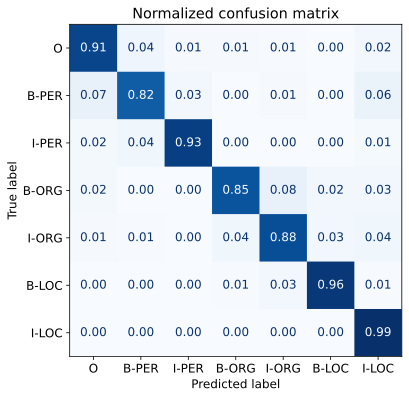

In [107]:
plot_confusion_matrix(df_tokens['labels'], df_tokens['predicted_label'], tags.names)

그래프를 보면, 모델은 B-ORG와 I-ORG를 가장 많이 혼동하는 경향을 보인다.  
그리고 B-PER는 O와 I-LOC와 많이 혼동하는 모습을 보인다.  
그 외 개체명은 잘 분류한다는 것이 오차 행렬의 주대각선에 잘 타나난다.

In [108]:
df_tokens

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
...,...,...,...,...,...,...
6289,242,1,O,0.00,O,▁'
6289,5106,1,O,0.00,O,▁''
6289,223660,1,B-PER,1.97,B-LOC,▁Alabama
6289,5106,1,O,0.00,O,▁''


In [109]:
tags

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

#### 토큰 수준에서 오류를 조사했으니 높은 손실을 내는 시퀀스를 알아보자.  
이 계산에서는 explode() 함수를 적용하기 전의 원래 DataFrame을 사용해서 토큰당 손실을 합산해 총 손실을 계산한다.  
#### 이를 위해 먼저 토큰 시퀀스, 레이블, 손실을 출력하는 함수를 작성한다.

In [110]:
def get_samples(df):
    for _, row in df.iterrows(): # df.iterrows()는 각 행을 반복하면서 (index, row_series -> row를 시리즈로)를 return한다.
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}: # i가 가장 처음(iterrows에서 가장 처음은 몇 번째 행인지 표시하는 index다.)과 (len(데이터개수) -> 0~4행이라면 i가 5 아래일 때)사이라면 아래 것들을 집어넣는다.
                labels.append(row['labels'][i])
                preds.append(row['predicted_label'][i])
                tokens.append(row['input_tokens'][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens,
                              "labels": labels,
                              "preds": preds,
                              "losses": losses}).T
        yield df_tmp

df['total_loss'] = df['loss'].apply(sum) # df에 total_loss 컬럼을 추가
df_tmp = df.sort_values(by='total_loss', ascending=False).head(3) # total_loss를 기준으로 정렬하는데 내림차순으로 처음 3개 -> 가장 큰 데이터 3개

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,O,O,O,O,O,B-ORG,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,3.32,0.00,0.00,0.00,8.20,9.81,8.18,9.81,9.81,0.00,9.81,9.81,0.00,9.81,9.81,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,7.34,0.00,0.00,4.95,6.29,7.78,6.95,0.00,7.95,9.16,8.19,8.15,5.60,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,6.46,5.24,5.55,0.00,5.59,0.00,5.44,0.00,5.34,5.54,5.91,6.05,5.67,5.48,0.00


In [111]:
df_tmp

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens,total_loss
3558,"[0, 242, 5106, 18141, 15020, 5106, 242, 242, 5...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, O, IGN, O, O, B-LOC, I-LOC, I-LOC,...","[0.0, 0.000932497, 0.000932497, 3.3169837, 0.0...","[O, O, O, B-ORG, O, O, O, O, O, B-ORG, O, O, O...","[<s>, ▁', ▁'', ▁Τ, Κ, ▁'', ▁', ▁', ▁'', ▁T, ▁'...",88.383646
5009,"[0, 5106, 1019, 5, 19838, 5106, 152, 75198, 27...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, B-ORG, IGN, IGN, I-ORG, I-ORG, I-ORG, I-...","[0.0, 7.3426404, 0.0, 0.0, 4.954851, 6.2915263...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-ORG,...","[<s>, ▁'', 8, ., ▁Juli, ▁'', ▁:, ▁Protest, cam...",72.383374
4671,"[0, 14098, 145704, 19335, 157955, 91969, 3674,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, B-PER, I-PER, I-PER, IGN, I-PER, IGN, I-...","[0.0, 6.456092, 5.2406664, 5.549491, 0.0, 5.58...","[O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, ...","[<s>, ▁United, ▁Nations, ▁Multi, dimensional, ...",62.265651


이 샘플의 레이블에 뭔가 문제가 있는 것 같다.  
가령 'United Nations'와 'Central African Republic'이 모두 사람(PER)로 레이블링 되어있다.  
또 두 번째 샘플의 'juli'는 조직으로 레이블링 되어있다.  
#### 이는 PAN-X 데이터셋의 레이블이 자동으로 생성됐다는 뜻이다.  
#### 이런 레이블을 종종 '실버 스탠다드 silver standard'라 한다. <-> 이와 대조적으로 사람이 생성한 레이블은 '골드 스탠다드 gold standard'
자동 방식이 합당한 레이블을 만들지 못하는 것은 당연하다.  
사실 이런 실패 사례는 자동 방식에만 국한되지 않는다.  
사람이 주의 깊게 데이터에 레이블을 부여할 때도 집중이 흐트러지거나 단순히 문장을 잘못 이해해서 실수가 생기기도 한다.

또 괄호와 슬래시의 손실이 비교적 높은 것 처럼 보인다.  
#### 시작 괄호가 있는 문장 샘플을 조금 더 살펴보자.

In [112]:
df_tmp = df.loc[df['input_tokens'].apply(lambda x: u"\u2581(" in x)].head(2)
df_tmp

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens,total_loss
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.0065526385, 0.0, 0.007075965, 0.006010...","[O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]",0.025667
44,"[0, 75165, 27099, 11, 15, 13212, 76, 1388, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, B-LOC, IGN, IGN, I-LOC, I-LOC, IGN, I-LO...","[0.0, 0.01421434, 0.0, 0.0, 0.013458945, 0.013...","[O, B-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-LOC, ...","[<s>, ▁Kesk, kül, a, ▁(, ▁Mart, na, ▁), </s>]",0.053376


In [113]:
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,0.01,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,O
losses,0.01,0.00,0.00,0.01,0.01,0.00,0.01,0.00


#### 일반적으로 괄호와 그 안의 내용을 개체명의 일부로 포함시키지 않지만 자동으로 레이블을 부여하는 시스템 때문에 발생한 문제인 것 같다.
두 번째 샘플에서 괄호는 지리적 위치를 감싸고 있다.  
이는 실제 위치이지만, 원래 위치와 레이블을 분리하고 싶을 때도 있다.  
(에스토니아에 있는 마을 Keskk\~는 2017년 전까지 Martna 교구에 속했으나 현재는 다른 교구에 속하므로 Keskk\~와 Martna가 독립적인 위치로 레이블링돼야 적절하다는 뜻이다.)  

이 데이터셋은 여러 언어의 위키피디아 문서로 구성되고 문서 제목에 있는 괄호에는 종종 어떤 설명이 담긴다.  
예를 들어 첫 번째 샘플에서 괄호 안의 텍스트는 Hama가 'Unternehmen', 즉 회사인 것을 나타낸다.  
이 점은 모델이 속한 전체 파이프라인의 성능에 영향을 미치기도 하므로 모델을 배포할 때 꼭 알아야 할 중요한 사항이다.

비교적 간단한 분석으로 모델과 데이터셋의 일부 약점을 찾아냈다.  
실전에서는 이런 과정을 반복해 목표한 성능에 도달할 때까지 데이터셋을 정제하고, 모델을 다시 훈련하고, 새로운 오류를 분석한다.

한 언어에 대한 오류를 분석했지만 언어 간 성능에도 관심이 있다.  
XLM-R에서 교차 언어 전이가 얼마나 잘 수행되는지를 다음 절에서 몇 가지 실험으로 알아보자.

# 4.10 교차 언어 전이

#### 독일어에서 XLM-R을 미세 튜닝했으므로 Trainer 클래스의 predict() 메서드를 사용해 다른 언어로 전이되는 능력을 평가해보자.
여러 언어를 평가할 계획이니 간단한 함수를 만듦.

In [114]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [115]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"[de] 데이터셋에서 [de] 모델의 f1_score: {f1_scores['de']['de']:.3f}")


[de] 데이터셋에서 [de] 모델의 f1_score: 0.870


ORG 개체명이 훈련 데이터에서 가장 적고, 많은 조직명이 XLM-R 어휘사전에 드물기 때문에 모델이 ORG 개체명에서 가장 큰 어려움을 겪는 것 같다.  
#### 다른 언어에서는 어떤지 독일어에서 미세 튜닝한 모델을 프랑스어에서 확인해보자.

In [117]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


#### 전체 데프랑스어 테스트 세트에서 독일어 모델의 성능을 계산해보자.
이를 위해 데이터셋을 인코딩하고 분류 리포트를 생성하는 간단한 함수를 작성한다.

In [118]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"[fr] 데이터셋에서 [de] 모델의 f1-score: {f1_scores['de']['fr']:.3f}")

[fr] 데이터셋에서 [de] 모델의 f1-score: 0.698


※마이크로 평균 점수로 약 17퍼센트 포인트가 감소했다.  
하지만 이 모델은 레이블링된 프랑스어 샘플을 하나도 본 적이 없다는 것을 기억해야 한다!  
일반적으로 성능 감소의 폭은 언어 간 차이가 얼마나 큰지에 좌우된다. (독일어와 프랑스어는 인도-유럽어족 언어로 묶이지만, 기술적으로 보면 게르만어파와 로망스어군에 각각 속한다.)  
#### ※seqeval의 f1_score() 함수는 클래스별 점수의 평균 방법을 지정하는 average 매개변수를 제공한다.
마이크로(micro) 평균은 클래스 레이블에 상관없이 전체 예측 결과를 사용해 점수를 계산하고,

#### 다음으로 이탈리아어에서 성능을 평가해보자.
이탈리아어도 로망스어군이니 프랑스어와 결과가 비슷하길 기대해볼 수 있다.

In [119]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"[it] 데이터셋에서 [de] 모델의 f1-score: {f1_scores['de']['it']:.3f}")

[it] 데이터셋에서 [de] 모델의 f1-score: 0.655


f1_score가 약간 차이 나기는 하는데 비슷하다고 보자. ㅋㅋ;

#### 마지막으로 게르만어파에 속하는 영어에서 성능을 평가해보자.

In [120]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"[en] 데이터셋에서 [de] 모델의 f1-score: {f1_scores['de']['en']:.3f}")

[en] 데이터셋에서 [de] 모델의 f1-score: 0.566


### 놀랍게도, 독일어가 프랑스어보다 영어와 더 가까우리라 예상했으나 오히려 모델 성능은 영어에서 가장 나쁘다.
여기서는 독일어에서 미세 튜닝하고 프랑스어와 영어에서 제로샷 전이 학습을 수행했다.  
#### 다음으로 언제 타깃 언어에서 직접 미세 튜닝을 해야 합리적인지 살펴보자.

## 4.10.1 제로샷 전이가 유용할 때

지금까지 독일어 말뭉치에서 미세 튜닝한 XLM-R이 약 85%의 f1_score를 얻고, 추가 훈련 없이 다른 언어 말뭉치에서 제법 좋은 성능을 달성했다.  
(이 결과가 얼마나 좋은지 판단하기 위해, 이 결과를 단일 언어에서 미세 튜닝한 XLM-R 모델과 어떻게 비교할까?)

#### 이 절에서는 프랑스어 말뭉치로 훈련 세트의 크기를 증가시키면서 XLM-R을 미세 튜닝해 독일어 XLM-R로 교차 언어 전이한 것보다 나은 결과를 내는 훈련 세트 크기를 구해보자.  
이는 실제로 레이블링된 데이터를 더 많이 수집해야 하는지 판단하는 데 유용하다.

간단하게 구성하기 위해 독일어 말뭉치에서 미세 튜닝할 때 사용한 파라미터를 사용한다.  
다만 TrainingArguments의 logging_steps 매개변수는 훈련 세트 크기에 맞춰 조정하자.  
단일 언어 말뭉치에 해당하는 DatasetDict 객체를 받고 num_samples만큼 샘플링해서 XML-R 모델을 미세 튜닝한 다음, 최상의 에포크에서 얻은 점수를 반환하는 간단한 함수를 만든다.

In [121]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size # 각 배치가 끝날 때마다 모델의 진행 상황 기록
    
    trainer = Trainer(model_init=model_init, args=training_args,
                     data_collator=data_collator, compute_metrics=compute_metrics,
                     train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")
    
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

### 독일어 말뭉치 미세 튜닝에서 한 것처럼, 프랑스어 말뭉치를 입력 ID, 어텐션 마스크, 레이블 ID로 인코딩한다.

In [122]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

#### 그 다음 250개 샘플로 구성된 작은 훈련 세트에서 이 함수를 실행한다.

In [123]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

/home/jj/github/NLP/nlp-with-transformers/xlm-roberta-base-finetuned-panx-de_ is already a clone of https://huggingface.co/bh8648/xlm-roberta-base-finetuned-panx-de_. Make sure you pull the latest changes with `repo.git_pull()`.
/home/jj/anaconda3/envs/deep/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,1.587000,1.205076,0.145212
2,1.007800,0.840312,0.397716
3,0.709100,0.748304,0.508232


Upload file pytorch_model.bin:   0%|                                                                      | 1.00/1.03G [00:00<?, ?B/s]
Upload file runs/Jul17_10-37-49_jj-System-Product-Name/events.out.tfevents.1689559781.jj-System-Product-Name.11737.1:   0%| | 1.00/6.0

Upload file tokenizer.json:   0%|                                                                         | 1.00/16.3M [00:00<?, ?B/s]


Upload file training_args.bin:   0%|                                                                      | 1.00/3.87k [00:00<?, ?B/s]


Upload file training_args.bin: 15.3MB [00:01, 16.0MB/s]                                                                               
Upload file runs/Jul17_10-37-49_jj-System-Product-Name/events.out.tfevents.1689559781.jj-System-Product-Name.11737.1: 15.3MB [00:01, 15.8MB/s]

Upload file pytorch_model.bin:   3%|█▊                                                           | 30.5M/1.03G [00:14<07:05, 2.54MB/s]


Upload file training_args.bin: 15.3MB [

,num_samples,f1_score
0,250,0.521169


#### sample 250개를 사용할 때는 프랑스어에서 미세 튜닝한 성능이 독일어에서 제로샷 전이로 얻은 결과보다 크게 떨어진다.  
#### 훈련 세트 크기를 500, 1000, 2000, 4000개로 늘려서 성능이 얼마나 좋아지는지 보자.

In [124]:
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(
        train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

/home/jj/github/NLP/nlp-with-transformers/xlm-roberta-base-finetuned-panx-de_ is already a clone of https://huggingface.co/bh8648/xlm-roberta-base-finetuned-panx-de_. Make sure you pull the latest changes with `repo.git_pull()`.
/home/jj/anaconda3/envs/deep/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,1.306000,0.893437,0.335773
2,0.697500,0.556144,0.570537
3,0.425300,0.469881,0.673083


Upload file pytorch_model.bin:   0%|                                                                      | 1.00/1.03G [00:00<?, ?B/s]
Upload file runs/Jul17_10-37-49_jj-System-Product-Name/events.out.tfevents.1689559990.jj-System-Product-Name.11737.2:   0%| | 1.00/6.0

Upload file training_args.bin:   0%|                                                                      | 1.00/3.87k [00:00<?, ?B/s]
Upload file runs/Jul17_10-37-49_jj-System-Product-Name/events.out.tfevents.1689559990.jj-System-Product-Name.11737.2: 15.3MB [00:01, 16.0MB/s]

Upload file pytorch_model.bin:  14%|████████▉                                                     | 153M/1.03G [00:18<01:38, 9.65MB/s]
Upload file runs/Jul17_10-37-49_jj-System-Product-Name/events.out.tfevents.1689559990.jj-System-Product-Name.11737.2: 15.3MB [00:18, 16.0MB/s]

Upload file pytorch_model.bin:  99%|████████████████████████████████████████████████████████████▋| 1.03G/1.03G [01:55<00:00, 9.01MB/s]To https://huggingface.co/bh8648/xlm-

/tmp/ipykernel_11737/334256818.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(
/home/jj/github/NLP/nlp-with-transformers/xlm-roberta-base-finetuned-panx-de_ is already a clone of https://huggingface.co/bh8648/xlm-roberta-base-finetuned-panx-de_. Make sure you pull the latest changes with `repo.git_pull()`.
/home/jj/anaconda3/envs/deep/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.916600,0.501444,0.668571
2,0.370600,0.391714,0.768137
3,0.237300,0.404683,0.786047


Upload file pytorch_model.bin:   0%|                                                                      | 1.00/1.03G [00:00<?, ?B/s]
Upload file runs/Jul17_10-37-49_jj-System-Product-Name/events.out.tfevents.1689560206.jj-System-Product-Name.11737.3:   0%| | 1.00/6.0

Upload file training_args.bin:   0%|                                                                      | 1.00/3.87k [00:00<?, ?B/s]

Upload file training_args.bin: 15.3MB [00:01, 16.0MB/s]                                                                               
Upload file pytorch_model.bin:  16%|█████████▊                                                    | 168M/1.03G [00:20<01:39, 9.41MB/s]5.9MB/s]
Upload file runs/Jul17_10-37-49_jj-System-Product-Name/events.out.tfevents.1689560206.jj-System-Product-Name.11737.3: 15.3MB [00:20, 15.9MB/s]

Upload file pytorch_model.bin: 1.04GB [02:28, 6.61MB/s]                                                                               To https://huggingface.co/bh8648/xlm-

/tmp/ipykernel_11737/334256818.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(
/home/jj/github/NLP/nlp-with-transformers/xlm-roberta-base-finetuned-panx-de_ is already a clone of https://huggingface.co/bh8648/xlm-roberta-base-finetuned-panx-de_. Make sure you pull the latest changes with `repo.git_pull()`.
/home/jj/anaconda3/envs/deep/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.663500,0.415891,0.753204
2,0.309100,0.348586,0.796043
3,0.185600,nan,0.000000


Upload file pytorch_model.bin:   0%|                                                                      | 1.00/1.03G [00:00<?, ?B/s]
Upload file training_args.bin:   0%|                                                                      | 1.00/3.87k [00:00<?, ?B/s]

Upload file runs/Jul17_10-37-49_jj-System-Product-Name/events.out.tfevents.1689560469.jj-System-Product-Name.11737.4:   0%| | 1.00/6.0

Upload file runs/Jul17_10-37-49_jj-System-Product-Name/events.out.tfevents.1689560469.jj-System-Product-Name.11737.4: 15.3MB [00:01, 16.0MB/s]
Upload file pytorch_model.bin:  10%|██████▎                                                       | 107M/1.03G [00:14<02:00, 8.28MB/s]

Upload file runs/Jul17_10-37-49_jj-System-Product-Name/events.out.tfevents.1689560469.jj-System-Product-Name.11737.4: 15.3MB [00:14, 16.0MB/s]
Upload file pytorch_model.bin: 1.04GB [02:03, 10.8MB/s]                                                                               To https://huggingface.co/bh8648/xlm-

/tmp/ipykernel_11737/334256818.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(
/home/jj/github/NLP/nlp-with-transformers/xlm-roberta-base-finetuned-panx-de_ is already a clone of https://huggingface.co/bh8648/xlm-roberta-base-finetuned-panx-de_. Make sure you pull the latest changes with `repo.git_pull()`.
/home/jj/anaconda3/envs/deep/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.562800,0.334186,0.794326


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


#### 훈련 세트 크기의 함수로 테스트 세트의 f1-score를 그래프로 그려서 프랑스어의 미세 튜닝과 독일어의 제로샷 교차 언어 전이를 비교해보자.

In [ ]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color='r') # de로 fine tuning 했을 때, fr 결과를 나타내는 f1_score 수평선 추가
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0,1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

훈련 샘플이 약 750개일 때까지 제로샷 전이가 앞서다가 그 후부터 프랑스어 미세 튜닝이 독일어에서 미세튜닝한 때와 비슷한 수준으로 성능이 향상된다.  
하지만 도메인 전문가를 고용해 수백 개의 문서를 레이블링하는 비용이 만만치 않기 때문에 제로샷 전이를 무시해서는 안된다.  
특히 NER에서 레이블링 과정은 복잡하고 시간이 많이 걸린다.

#### 다중 언어 학습을 평가하는 마지막 방법은 다국어에서 동시에 미세 튜닝하는 것이다.

## 4.10.2 다국어에서 동시에 미세 튜닝하기

독일어에서 프랑스어나 이탈리아어로 수행된 제로샷 교차 언어 전이에서 성능이 약 15퍼센트 포인트 떨어졌다.  
성능 감소의 폭을 줄이는 방법 하나는 다국어에서 동시에 미세 튜닝하는 것.  

#### 어떤 이득이 있는지 보기 위해 데이터셋의 concatenate_datasets() 함수를 사용해 먼저 독일어와 프랑스어 말뭉치를 합쳐보자.

In [1]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

/home/jj/anaconda3/envs/deep/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 이전 절과 같은 하이퍼파라미터를 사용해 훈련하므로 Trainer에 있는 logging_steps, 모델, 데이터셋을 간단히 바꾼다.

In [ ]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base_finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
                 data_collator=data_collator, compute_metrics=compute_metrics,
                 tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
                 eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

#### 각 언어의 테스트 세트에서 모델의 성능을 확인해보자.

In [ ]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
   print(f"[{lang}] 데이터셋에서 [de-fr] 모델의 F1-점수: {f1:.3f}")

프랑스어 테스트 성능이 이전보다 훨씬 더 좋아져 독일어 테스트 세트 성능과 비슷하다.  
흥미롭게도 이탈리아어와 영어 성능도 약 10퍼센트 포인트 향상됐다!  
따라서 다른 언어의 훈련 데이터를 추가해도, 본 적 없는 언어에서 모델의 성능이 향상된다.  

각 언어에서 미세 튜닝한 성능과 전체 말뭉치에서 수행한 다중 언어 학습을 비교하면서 분석을 마무리해보자.  
이미 독일어 말뭉치에서 미세 튜닝했으니 나머지 언어를 train_on_subset() 함수로 미세 튜닝한다.  
num_samples 매개변수는 훈련 세트에 있는 샘플 개수로 지정한다.

In [ ]:
corpora = [panx_de_encoded]

# 반복에서 독일어는 제외한다.
for lang in langs[1:] :
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # 단일 언어 말뭉치에서 미세 튜닝한다.
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # 딕셔너리에 f1-score를 모은다.
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # 단일 언어 말뭉치를 corpora 리스트에 추가한다.
    corpora.append(ds_encoded)

각 언어 말뭉치에서 미세튜닝 했으니, 다음으로 모든 언어의 분할을 합쳐서 네 언어로 구성된 다국어 말뭉치를 만든다.  
이를 위해 앞의 독일어와 프랑스어를 합칠 때처럼, concatenate_splits() 함수에 위에서 생성한 말뭉치 리스트를 적용한다.

In [ ]:
corpora_encoded = concatenate_splits(corpora)

#### 다국어 말뭉치가 준비됐으니 이제 익숙한 Trainer를 실행할 단계다.

In [ ]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
                 data_collator=data_collator, compute_metrics=compute_metrics,
                 tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
                 eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

마지막 단계로 trainer를 사용해 각 언어의 테스트 세트에 대한 예측을 생성.  
이 과정에서 다중 언어 학습이 실제로 얼마나 잘 작동하는지 통찰을 얻게 된다.  
f1_scores 딕셔너리에 f1-score를 저장하고 다중 언어 실험의 주요 결과를 요약한 DataFrame을 만든다.

In [ ]:
for idx, lang in enumerate(langs) :
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

In [ ]:
socres_data = {"de": f1_scores,
            "each": {lang : f1_score[lang][lang] for lang in langs},
              "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(score_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                        inplace=True)
f1_scores_df

# 결론

이 장에서 100개 언어에서 사전 훈련된 트랜스포머 모델 XLM-R로 다국어 말뭉치가 있는 NLP 작업을 처리했다.  
독일어에서 프랑스어로 교차 언어 전이는 미세 튜닝에 사용할 레이블링된 샘플이 적을 때만 경쟁력 있는 방법이라는 사실을 확인했다.  
교차 언어 전이는 일반적으로 타깃 언어가 베이스 모델의 미세 튜닝에 사용한 언어와 크게 다르거나 사전 훈련에 사용된 100개 언어 중 하나가 아니라면 좋은 성능을 내지 못합니다.  
MAD-X 같은 최근 연구는 이렇게 데이터가 부족한 상황을 위해 설계됐다.  
MAD-X는 트랜스포머스 위에 구축됐으므로 이용하고 싶다면 이 장의 코드를 조금 바꾸면 된다.

지금까지 시퀀스 분류와 토큰 분류 작업을 살펴봤다.  
두 작업은 모두 텍스트를 사용해 예측을 만드는 자연어 이해 분야에 속한다.  
다음 장에서는 처음으로 텍스트 생성에 대해 알아보겠다. (여기서는 모델의 입력과 출력이 텍스트다.)

In [70]:
torch.cuda.memory_allocated()

3346760192

In [67]:
torch.cuda.memory_reserved() 

6274678784

In [68]:
torch.cuda.empty_cache() # torch.cuda.empty_cache()는 torch.cuda.memory_reserved() 에서 보이는 만큼을 free하게 해줍니다